In [76]:
import numpy as np
import seaborn as sns
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from skpsl import ProbabilisticScoringList

from experiments.util import DataLoader

# fit psl and get a instance of the calibrator


In [77]:
X, y = DataLoader("./experiments/data").load("thorax")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 / 3, random_state=4)
pipeline = make_pipeline(
    SimpleImputer(missing_values=-1, strategy="most_frequent"),
    ProbabilisticScoringList({1, 2, 3}).fit(X, y),
)

In [78]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(missing_values=-1, strategy='most_frequent')),
                ('probabilisticscoringlist',
                 ProbabilisticScoringList(score_set={1, 2, 3}))])

In [79]:
from sklearn.metrics import confusion_matrix

def conservative_weighted_loss(y_true, y_prob, m=10, *, sample_weight=None):
    if y_prob.shape[1] == 3:
        lb, _, ub = y_prob.T
    else:
        ub = y_prob[:,1]
        tn, fp, fn, tp = confusion_matrix(y_true, 1 - ub < m * ub, sample_weight=sample_weight, normalize="all", labels=[True,False]).ravel()
    print(tn, fp, fn, tp)
    return fp + m * fn


In [80]:
imputer = pipeline[0]
psl = pipeline[1]

X_test = imputer.transform(X_test)

In [81]:
psl_short = psl[:4]

In [82]:
import networkx as nx


def create_dag(psl):
    dag = nx.DiGraph()
    for stage, (first, second) in enumerate(zip(psl, psl[1:])):
        tscores = first.class_counts_per_score.keys() 
        score = second.scores[-1]
        for tscore in tscores:
            first_neg = first.class_counts_per_score[tscore][0]
            first_pos = first.class_counts_per_score[tscore][1]
            first_proba = first.calibrator.transform(np.array([tscore])).item()
            second_0_neg = second.class_counts_per_score[tscore][0]
            second_0_pos = second.class_counts_per_score[tscore][1]
            second_0_proba = second.calibrator.transform(np.array([tscore])).item()
            second_1_neg = second.class_counts_per_score[tscore+score][0]
            second_1_pos = second.class_counts_per_score[tscore+score][1]
            second_1_proba = second.calibrator.transform(np.array([tscore+score])).item()
            
            dag.add_node((stage,tscore), num_neg = first_neg, num_pos = first_pos, proba = first_proba)
            dag.add_node((stage+1,tscore), num_neg = second_0_neg, num_pos = second_0_pos, proba = second_0_proba)
            dag.add_node((stage+1,tscore+score),num_neg = second_1_neg, num_pos = second_1_pos, proba = second_1_proba)
            # case 1: Feature ist not active
            dag.add_edge((stage,tscore),(stage+1,tscore),score=0)
            # case 1: Feature ist active
            dag.add_edge((stage,tscore),(stage+1,tscore+score),score=score)
    return dag

In [83]:
psl.inspect(k=3)

,Stage,Feature Index,Score,T = 0,T = 1,T = 2,T = 3,T = 4,T = 5,T = 6
0,0,NaN,NaN,0.143930,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5.0,3.0,0.083082,NaN,NaN,0.437956,NaN,NaN,NaN
2,2,2.0,2.0,0.029570,NaN,0.151724,0.437956,NaN,0.437956,NaN
3,3,4.0,1.0,0.016667,0.083333,0.128205,0.283784,0.344444,0.344444,0.758621


{((0, 0),
  (1, 0)): Text(0.5000032662646848, 2.220446049250313e-16, "{'score': 0}"),
 ((0, 0),
  (1, 3)): Text(0.4999981316505001, 1.4999943949515007, "{'score': 3}"),
 ((1, 0),
  (2, 0)): Text(1.500003266264685, 2.220446049250313e-16, "{'score': 0}"),
 ((1, 0),
  (2, 2)): Text(1.5000029503135015, 1.0000059006270023, "{'score': 2}"),
 ((1, 3), (2, 3)): Text(1.500003266264685, 3.0, "{'score': 0}"),
 ((1, 3), (2, 5)): Text(1.5000029503135015, 4.000005900627003, "{'score': 2}"),
 ((2, 0),
  (3, 0)): Text(2.500003266264686, 2.220446049250313e-16, "{'score': 0}"),
 ((2, 0),
  (3, 1)): Text(2.4999925905140126, 0.49999259051401235, "{'score': 1}"),
 ((2, 2), (3, 2)): Text(2.500003266264686, 2.000000000000001, "{'score': 0}"),
 ((2, 2),
  (3, 3)): Text(2.4999925905140126, 2.4999925905140126, "{'score': 1}"),
 ((2, 3), (3, 3)): Text(2.500003266264686, 3.0, "{'score': 0}"),
 ((2, 3),
  (3, 4)): Text(2.4999925905140126, 3.4999925905140117, "{'score': 1}"),
 ((2, 5), (3, 5)): Text(2.5000032662646

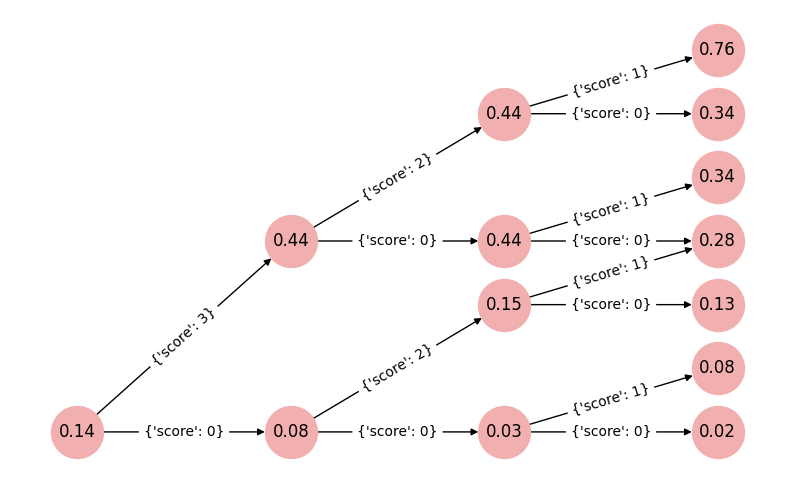

In [84]:
from matplotlib import figure

dag = create_dag(psl_short)
pos = {x:x for x in dag.nodes}
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
node_labels = {
    node: f"{dag.nodes[node]['proba']:.2f}"
    for node in dag.nodes}
nx.draw(dag, pos, with_labels = False,ax=ax, node_size=1400, node_color="#F1AFAF")
nx.draw_networkx_labels(dag, pos, node_labels)
nx.draw_networkx_edge_labels(dag,pos=pos)

In [94]:
from scipy.stats import entropy
from collections import defaultdict
import numpy as np

def expected_loss(y_prob,m=10):
    ub = y_prob[:,1].item()
    y_decision = 1 - ub < m * ub    
    if y_decision == True:
        return (1 - ub) * 1
    else:
        return ub * 10


def calculate_evois(dag, loss=expected_loss, weight_by_bucket_size=False):
    evois = {}
    for node in dag.nodes:

        proba = dag.nodes[node]["proba"]
        current_loss = loss(np.array([[proba, 1-proba]]))

        children = dag.successors(node)
        successors = nx.single_source_shortest_path_length(dag, node)
        largest_dist = max(successors.values())
        node_evois = {}
        for dist in range(1,largest_dist+1):
            succs_at_dist = [k for k,v in successors.items() if int(v) == dist]
            succ_losses, weights = [], []
            for succ in succs_at_dist:
                succ_losses.append(loss(np.array([[dag.nodes[succ]["proba"], 1-dag.nodes[succ]["proba"]]])))
                if weight_by_bucket_size:
                    weights.append(dag.nodes[succ]["num_pos"] + dag.nodes[succ]["num_neg"])
                else:
                    weights.append(1)
            if succ_losses:
                succ_losses, weights = np.array(succ_losses), np.array(weights)
                expected_loss_reduction = np.average(np.full_like(succ_losses, current_loss) - succ_losses, weights = weights)
                node_evois[dist] = expected_loss_reduction / dist
        evois[node] = node_evois
    evois = defaultdict(dict,evois)
    return evois
calculate_evois(dag)


defaultdict(dict,
            {(0, 0): {1: -0.11658897529778234,
              2: -0.06018584870016554,
              3: -0.04533281446664555,
              4: -0.023609998695606756,
              5: -0.02060342582455265,
              6: -0.015556293690703944,
              7: -0.012644233461116807,
              8: -0.008287910434093826,
              9: -0.006781380240783203,
              10: -0.0023954580563916193},
             (1, 0): {1: -0.007565444205097471,
              2: -0.022457828500124566,
              3: -0.007619275575193649,
              4: -0.01895269516257981,
              5: -0.014408464493356038,
              6: -0.01246545713160898,
              7: -0.008436190928953674,
              8: -0.007055788653892432,
              9: -0.012367888865814601},
             (1, 3): {1: 0.0,
              2: 0.002566431898800403,
              3: 0.03522680322815152,
              4: 0.028690238277135866,
              5: 0.02763749641208956,
              6: 0.02559

In [98]:
per_instance_budget = 3
overall_budget = per_instance_budget * len(y_test)
voi = 0.10
# Predictions when always evaluation the same amount of features per instance
y_prob_non_adaptive = pipeline.predict_proba(X_test, k=per_instance_budget)


# Instantiate dag for heuristic
dag = create_dag(psl=psl)
evois = calculate_evois(dag)
y_prob_adaptive = []
remaining_budget = overall_budget
imputer = pipeline[0]
psl = pipeline[1]

X_test = imputer.transform(X_test)

for x_test in X_test:
    x_test = x_test.reshape(1,-1)    
    stage = 0
    current_score = int(psl[stage]._compute_total_scores(
            x_test, psl[stage].features, psl[stage].scores_, psl[stage].feature_thresholds
        ).item())
    current_proba = psl.predict_proba(x_test, k=stage)[0]

    while any(evoi >= voi for evoi in evois[(stage,current_score)].values()) and remaining_budget - stage > 0:
        stage += 1
        current_score = psl[stage]._compute_total_scores(
                x_test, psl[stage].features, psl[stage].scores_, psl[stage].feature_thresholds
            ).item()
        current_proba = psl.predict_proba(x_test, k=stage)[0]
    
    remaining_budget -= stage

    y_prob_adaptive.append(current_proba)
    print(remaining_budget)
y_prob_adaptive = np.stack(y_prob_adaptive)

1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200


In [99]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
bacc_adap = balanced_accuracy_score(y_test, y_prob_adaptive.argmax(axis=1))
bacc_non_adap = balanced_accuracy_score(y_test, y_prob_non_adaptive.argmax(axis=1))

cwloss_adap = conservative_weighted_loss(y_test, y_prob_adaptive)
cwloss_non_adap = conservative_weighted_loss(y_test, y_prob_non_adaptive)


0.1625 0.0 0.8375 0.0
0.145 0.0175 0.375 0.4625


In [100]:
print("non adaptive:", cwloss_non_adap, bacc_non_adap)
print("non adaptive:", cwloss_adap, bacc_adap)

non adaptive: 3.7675 0.618828932261768
non adaptive: 8.375 0.5
